In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import scipy.stats
from tqdm import tqdm

# Define the directories
base_dir = "Data/genres_original"  # Path to the folder containing genre subfolders
genres = os.listdir(base_dir)

# Define column names for the DataFrame
column_names = ['file_name', 'genre', 'signal_mean', 'signal_std', 'signal_skew', 'signal_kurtosis',
                'zcr_mean', 'zcr_std', 'rms_mean', 'rms_std', 'tempo', 'spectral_centroid_mean',
                'spectral_centroid_std', 'spectral_bandwidth2_mean', 'spectral_bandwidth2_std',
                'spectral_bandwidth3_mean', 'spectral_bandwidth3_std', 'spectral_bandwidth4_mean',
                'spectral_bandwidth4_std'] + \
               ['spectral_contrast_' + str(i + 1) + '_mean' for i in range(7)] + \
               ['spectral_contrast_' + str(i + 1) + '_std' for i in range(7)] + \
               ['spectral_rolloff_mean', 'spectral_rolloff_std'] + \
               ['mfccs_' + str(i + 1) + '_mean' for i in range(20)] + \
               ['mfccs_' + str(i + 1) + '_std' for i in range(20)] + \
               ['chroma_stft_' + str(i + 1) + '_mean' for i in range(12)] + \
               ['chroma_stft_' + str(i + 1) + '_std' for i in range(12)]

# Initialize an empty list for features
extracted_features = []

# Parse through each genre folder and extract features
for genre in tqdm(genres):
    genre_dir = os.path.join(base_dir, genre)
    if not os.path.isdir(genre_dir):  # Skip if not a directory
        continue
    audio_files = [f for f in os.listdir(genre_dir) if f.endswith('.wav')]
    for file in audio_files:
        try:
            file_path = os.path.join(genre_dir, file)
            y, sr = librosa.load(file_path, sr=22050)

            feature_list = [file, genre]  # Add file name and genre

            # Extract features
            feature_list.append(np.mean(abs(y)))
            feature_list.append(np.std(y))
            feature_list.append(scipy.stats.skew(abs(y)))
            feature_list.append(scipy.stats.kurtosis(y))

            zcr = librosa.feature.zero_crossing_rate(y + 0.000001, frame_length=2048, hop_length=512)[0]
            feature_list.append(np.mean(zcr))
            feature_list.append(np.std(zcr))

            rms = librosa.feature.rms(y=y + 0.0001)[0]
            feature_list.append(np.mean(rms))
            feature_list.append(np.std(rms))

            tempo = librosa.feature.tempo(y=y, sr=sr)
            feature_list.append(np.mean(tempo))

            spectral_centroids = librosa.feature.spectral_centroid(y=y + 0.01, sr=sr)[0]
            feature_list.append(np.mean(spectral_centroids))
            feature_list.append(np.std(spectral_centroids))

            spectral_bandwidth2 = librosa.feature.spectral_bandwidth(y=y + 0.01, sr=sr, p=2)[0]
            spectral_bandwidth3 = librosa.feature.spectral_bandwidth(y=y + 0.01, sr=sr, p=3)[0]
            spectral_bandwidth4 = librosa.feature.spectral_bandwidth(y=y + 0.01, sr=sr, p=4)[0]
            feature_list.append(np.mean(spectral_bandwidth2))
            feature_list.append(np.std(spectral_bandwidth2))
            feature_list.append(np.mean(spectral_bandwidth3))
            feature_list.append(np.std(spectral_bandwidth3))
            feature_list.append(np.mean(spectral_bandwidth4))
            feature_list.append(np.std(spectral_bandwidth4))

            spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=6, fmin=200.0)
            feature_list.extend(np.mean(spectral_contrast, axis=1))
            feature_list.extend(np.std(spectral_contrast, axis=1))

            spectral_rolloff = librosa.feature.spectral_rolloff(y=y + 0.01, sr=sr, roll_percent=0.85)[0]
            feature_list.append(np.mean(spectral_rolloff))
            feature_list.append(np.std(spectral_rolloff))

            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
            feature_list.extend(np.mean(mfccs, axis=1))
            feature_list.extend(np.std(mfccs, axis=1))

            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=1024)
            feature_list.extend(np.mean(chroma_stft, axis=1))
            feature_list.extend(np.std(chroma_stft, axis=1))

            feature_list[2:] = np.round(feature_list[2:], decimals=3)
            extracted_features.append(feature_list)
        except Exception as e:
            print(f"Error processing {file} in genre {genre}: {e}")

# Create DataFrame
df = pd.DataFrame(extracted_features, columns=column_names)

# Save to CSV for further analysis
#df.to_csv("gtzan_features.csv", index=False)

#print("Feature extraction completed. Data saved to gtzan_features.csv.")


  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Logang 4 Lyfe\AppData\Local\Temp\ipykernel_7528\1946393973.py:56: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(y=y, sr=sr)
 50%|█████     | 5/10 [04:59<04:58, 59.68s/it]C:\Users\Logang 4 Lyfe\AppData\Local\Temp\ipykernel_7528\1946393973.py:38: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=22050)
c:\Python312\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing jazz.00054.wav in genre jazz: 


100%|██████████| 10/10 [09:29<00:00, 56.97s/it]


In [4]:
df.head()
print(df.isnull().sum())
df.shape

file_name             0
genre                 0
signal_mean           0
signal_std            0
signal_skew           0
                     ..
chroma_stft_8_std     0
chroma_stft_9_std     0
chroma_stft_10_std    0
chroma_stft_11_std    0
chroma_stft_12_std    0
Length: 99, dtype: int64


(999, 99)

In [3]:
# Save to CSV for further analysis
df.to_csv("gtzan_features.csv", index=False)

print("Feature extraction completed. Data saved to gtzan_features.csv.")

NameError: name 'df' is not defined

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Load Dataset
dataset = pd.read_csv("gtzan_features.csv")


dataset.head()

,file_name,genre,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rms_mean,rms_std,...,chroma_stft_3_std,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std
0,blues.00000.wav,blues,0.103,0.141,1.610,1.581,0.083,0.028,0.130,0.053,...,0.315,0.215,0.251,0.289,0.282,0.344,0.251,0.278,0.331,0.294
1,blues.00001.wav,blues,0.076,0.108,1.772,2.337,0.056,0.038,0.096,0.049,...,0.308,0.228,0.214,0.316,0.286,0.367,0.292,0.233,0.278,0.267
2,blues.00002.wav,blues,0.140,0.183,1.322,0.734,0.076,0.032,0.175,0.052,...,0.265,0.268,0.350,0.242,0.244,0.249,0.241,0.331,0.251,0.353
3,blues.00003.wav,blues,0.115,0.162,1.428,1.331,0.033,0.021,0.141,0.080,...,0.326,0.305,0.346,0.306,0.237,0.202,0.215,0.291,0.279,0.336
4,blues.00004.wav,blues,0.071,0.103,2.246,3.995,0.101,0.044,0.092,0.048,...,0.308,0.266,0.177,0.357,0.198,0.181,0.301,0.232,0.360,0.209


In [5]:
from sklearn.preprocessing import MinMaxScaler

le = LabelEncoder()
dataset['Genre_Label'] = le.fit_transform(dataset['genre'])

#Extract features and labels
X = dataset.drop(columns=['file_name', 'genre'])
y = dataset['Genre_Label']

#Normalize the features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#Stratified K-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_reg = LogisticRegression(max_iter=1000, multi_class='ovr', penalty='l2', random_state=42)
lr_scores = cross_val_score(log_reg, X_normalized, y, cv=cv, scoring='accuracy')
print("Logistic Regression Cross-Validation Accuracy Scores:", lr_scores)
print("Logistic Regression Mean Accuracy:", lr_scores.mean())

#Cross-validation predictions
y_lr_pred = cross_val_predict(log_reg, X_normalized, y, cv=cv)

#Classification Report 
print("Logistic Regression Classification Report:")
print(classification_report(y, y_lr_pred))

#confusion matrix
cm_lr = confusion_matrix(y, y_lr_pred)
print("Logistic Regression Confusion Matrix:\n", cm_lr)

Logistic Regression Cross-Validation Accuracy Scores: [0.9   0.875 0.85  0.875 0.875]
Logistic Regression Mean Accuracy: 0.875
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       100
           1       0.96      0.95      0.95       100
           2       0.85      0.81      0.83       100
           3       0.75      0.79      0.77       100
           4       0.84      0.81      0.83       100
           5       0.99      0.90      0.94       100
           6       0.90      0.94      0.92       100
           7       0.86      0.90      0.88       100
           8       0.85      0.80      0.82       100
           9       0.85      0.88      0.86       100

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.87      1000
weighted avg       0.88      0.88      0.87      1000

Logistic Regression Confusion Matrix:
 [[97  0  1  2  0  0  0  0  0  0]

In [7]:
from sklearn.ensemble import RandomForestClassifier
#Initialize and train Random Forest
rf_model = RandomForestClassifier(n_estimators=500, random_state=42, min_samples_split=5)

# Cross-validation scores
rf_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='accuracy')
print("Random Forest Cross-Validation Accuracy Scores:", rf_scores)
print("Random Forest Mean Accuracy:", rf_scores.mean())

#Cross-validation predictions
y_rf_pred = cross_val_predict(rf_model, X, y, cv=cv)

#Classification report
print("Random Forest Classification Report:")
print(classification_report(y, y_rf_pred))

#Confusion matrix
cm_rf = confusion_matrix(y, y_rf_pred)
print("Random Forest Confusion Matrix:\n", cm_rf)

Random Forest Cross-Validation Accuracy Scores: [0.93  0.9   0.935 0.935 0.895]
Random Forest Mean Accuracy: 0.9190000000000002
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       100
           1       0.97      0.96      0.96       100
           2       0.89      0.93      0.91       100
           3       0.88      0.89      0.89       100
           4       0.89      0.88      0.88       100
           5       0.96      0.95      0.95       100
           6       0.92      0.95      0.94       100
           7       0.90      0.88      0.89       100
           8       0.88      0.86      0.87       100
           9       0.92      0.90      0.91       100

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000

Random Forest Confusion Matrix:
 [[99  0  0  1  0  0  0  0  0  0]
 [ 0 96  2

In [8]:
from sklearn.svm import SVC
#SVM with RBF Kernel
svm_model = SVC(kernel='rbf', C=1000.0, gamma='scale', probability=True, random_state=42)

#Cross validation scores
svm_scores = cross_val_score(svm_model, X_normalized, y, cv=cv, scoring='accuracy')
print("SVM Cross-Validation Accuracy Scores:", svm_scores)
print("SVM Mean Accuracy:", svm_scores.mean())

#Cross validation predictions
y_svm_pred = cross_val_predict(svm_model, X_normalized, y, cv=cv)

#Classification report 
print("SVM Classification Report:")
print(classification_report(y, y_svm_pred))

#Confusion matrix
cm_svm = confusion_matrix(y, y_svm_pred)
print("SVM Confusion Matrix:\n", cm_svm)

SVM Cross-Validation Accuracy Scores: [0.94  0.92  0.94  0.925 0.9  ]
SVM Mean Accuracy: 0.925
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       100
           1       0.98      0.96      0.97       100
           2       0.92      0.93      0.93       100
           3       0.88      0.91      0.89       100
           4       0.92      0.92      0.92       100
           5       0.98      0.96      0.97       100
           6       0.97      0.98      0.98       100
           7       0.87      0.88      0.88       100
           8       0.85      0.82      0.84       100
           9       0.89      0.90      0.90       100

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.92      1000
weighted avg       0.93      0.93      0.92      1000

SVM Confusion Matrix:
 [[99  0  1  0  0  0  0  0  0  0]
 [ 1 96  2  1  0  0  0  0  0  0]
 [ 0  1 93  6  0  0  0  0  0  

In [9]:
from xgboost import XGBClassifier
#XGBoost model
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)

#Cross-validation scores
xgb_scores = cross_val_score(xgb_model, X, y, cv=cv, scoring='accuracy')
print("XGBoost Cross-Validation Accuracy Scores:", xgb_scores)
print("XGBoost Mean Accuracy:", xgb_scores.mean())

#Cross-validation predictions
y_xgb_pred = cross_val_predict(xgb_model, X, y, cv=cv)

#Classification report
print("XGBoost Classification Report:")
print(classification_report(y, y_xgb_pred))

#Confusion matrix
cm_xgb = confusion_matrix(y, y_xgb_pred)
print("XGBoost Confusion Matrix:\n", cm_xgb)

XGBoost Cross-Validation Accuracy Scores: [1.    1.    0.995 1.    1.   ]
XGBoost Mean Accuracy: 0.999
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00       100
           5       1.00      1.00      1.00       100
           6       1.00      0.99      0.99       100
           7       0.99      1.00      1.00       100
           8       1.00      1.00      1.00       100
           9       1.00      1.00      1.00       100

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

XGBoost Confusion Matrix:
 [[100   0   0   0   0   0   0   0   0   0]
 [  0 100   0   0   0   0   0   0   0

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split the data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Fit and predict for each model
models = {'Logistic Regression': log_reg, 'Random Forest': rf_model, 'SVM': svm_model, 'XGBoost': xgb_model}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.95      0.81        20
           1       1.00      1.00      1.00        13
           2       1.00      0.63      0.77        27
           3       0.74      0.67      0.70        21
           4       0.70      0.93      0.80        15
           5       1.00      0.90      0.95        21
           6       0.96      0.96      0.96        26
           7       0.73      0.85      0.79        13
           8       0.84      0.73      0.78        22
           9       0.80      0.91      0.85        22

    accuracy                           0.84       200
   macro avg       0.85      0.85      0.84       200
weighted avg       0.86      0.84      0.84       200


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      1.00      1.00       

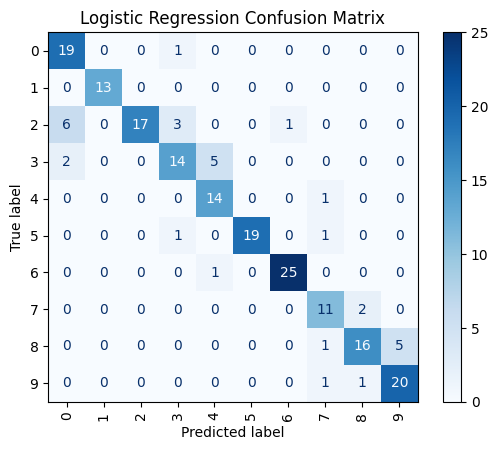

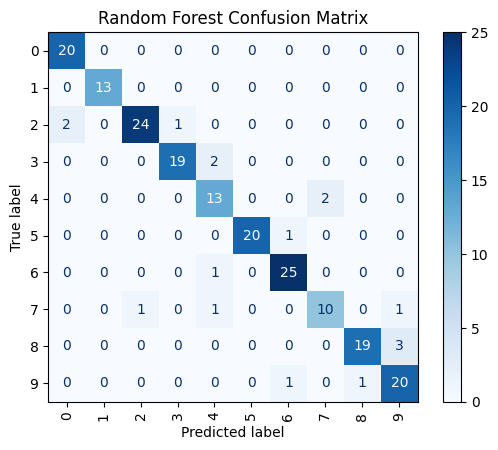

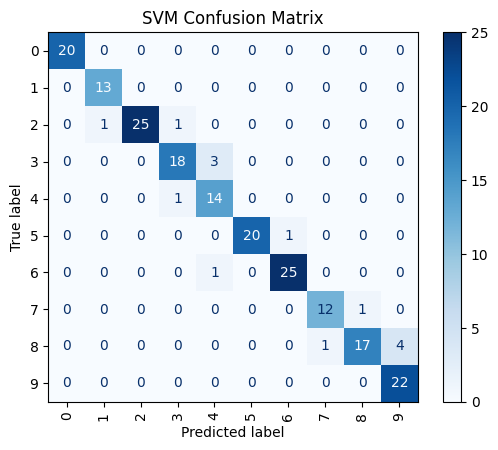

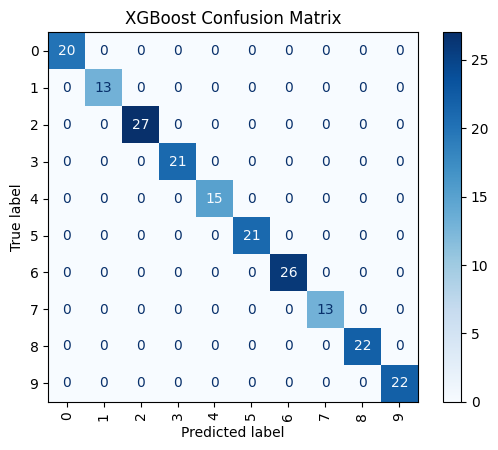

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#Confusion Matrices based on the typical train test split (70/30)
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=y.unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y.unique())
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title(f"{name} Confusion Matrix")
    plt.show()


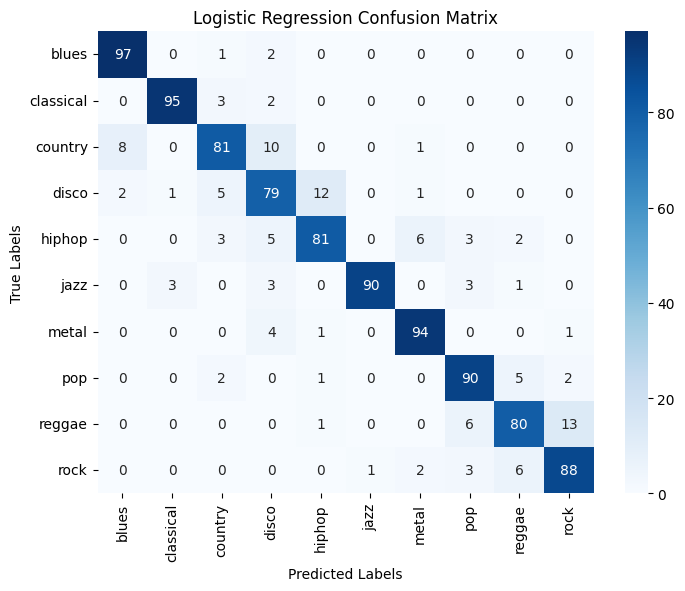

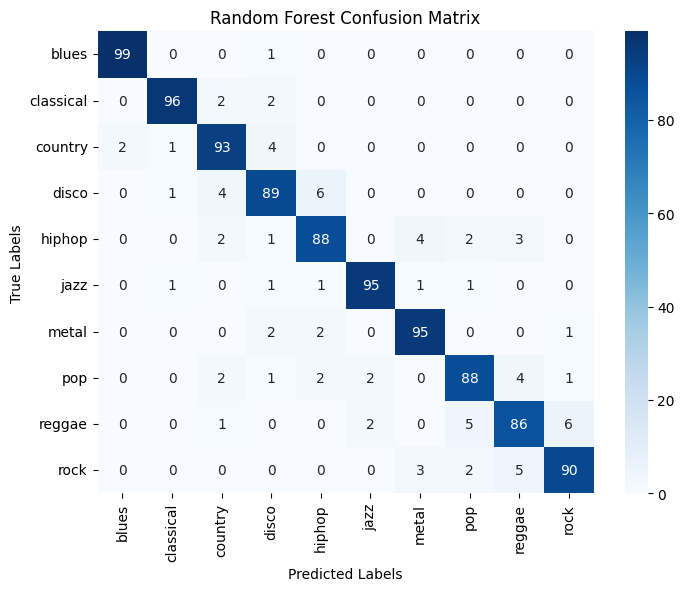

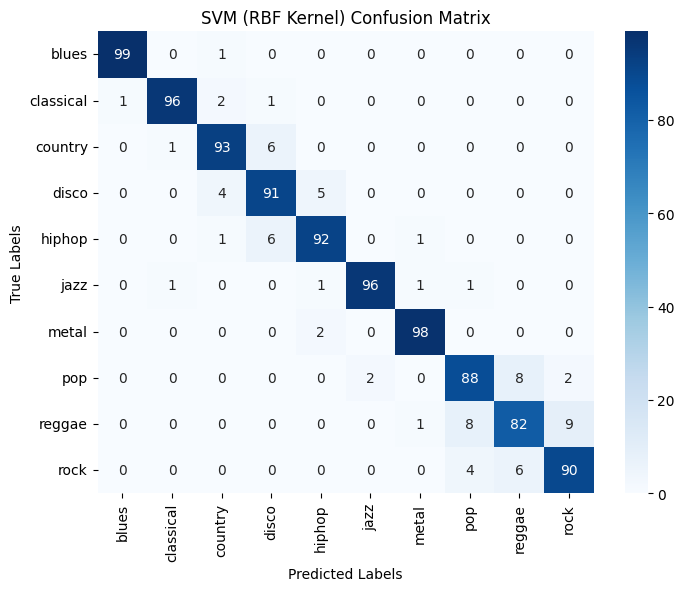

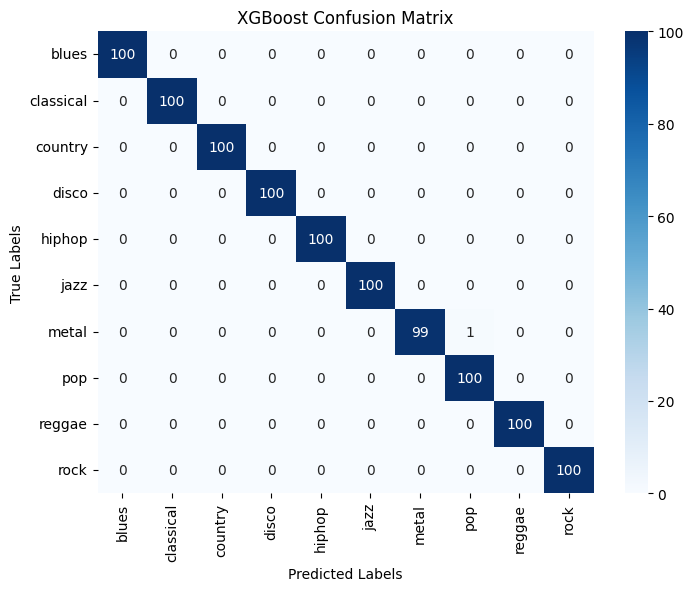

In [12]:
#Confusion Matrices for the models based off the cross validation results
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    plt.show()

plot_confusion_matrix(cm_lr, "Logistic Regression")
plot_confusion_matrix(cm_rf, "Random Forest")
plot_confusion_matrix(cm_svm, "SVM (RBF Kernel)")
plot_confusion_matrix(cm_xgb, "XGBoost")

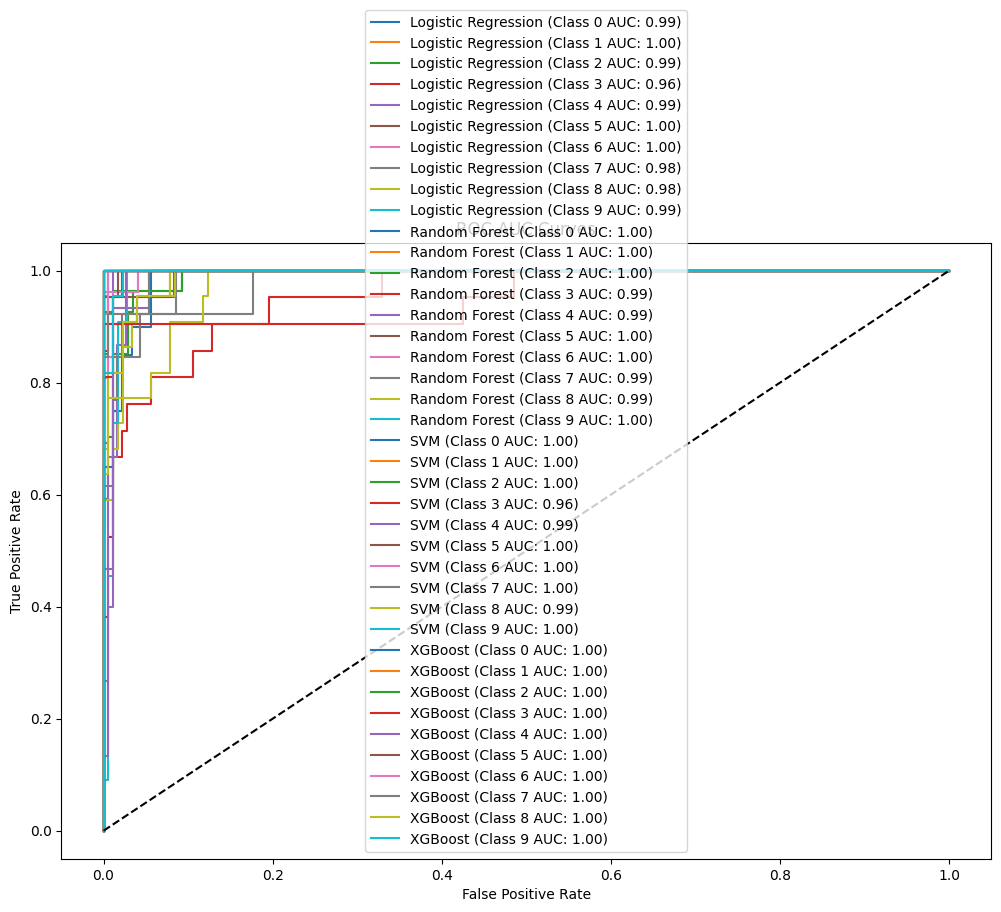

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels for multi-class ROC-AUC
y_binarized = label_binarize(y_test, classes=y.unique())
n_classes = y_binarized.shape[1]

plt.figure(figsize=(12, 8))

for name, model in models.items():
    y_proba = model.predict_proba(X_test)
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_binarized[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (Class {i} AUC: {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC-AUC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.show()
